<h1>One to One</h1>

In [1]:
#link kaggle: https://www.kaggle.com/hnganhlnguyn/ex5-rnn-lstm-1
#link dataset: https://www.kaggle.com/hnganhlnguyn/aapldataset
#Author by Hung Anh
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
import numpy
import matplotlib.pyplot as plt
import math
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

<h1>Prepare Data</h1>

In [3]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
    #t
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
    #t+1
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [4]:
dataframe = pd.read_csv("../input/aapldataset/AAPL.csv",index_col=0)
dataframe.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-11-14,26.927500,26.952499,26.020000,26.427500,24.825821,204702000
2016-11-15,26.642500,26.920000,26.540001,26.777500,25.154610,129058000
2016-11-16,26.674999,27.557501,26.650000,27.497499,25.830971,235362000
2016-11-17,27.452499,27.587500,27.207500,27.487499,25.821573,110528000
2016-11-18,27.430000,27.635000,27.415001,27.514999,25.847408,113715600


In [5]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1008 entries, 2016-11-14 to 2020-11-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1008 non-null   float64
 1   High       1008 non-null   float64
 2   Low        1008 non-null   float64
 3   Close      1008 non-null   float64
 4   Adj Close  1008 non-null   float64
 5   Volume     1008 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 55.1+ KB


In [6]:
dataframe.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1.008000e+03
mean,55.022847,55.634645,54.439440,55.068780,53.661965,1.279139e+08
std,22.808228,23.199504,22.329356,22.778370,23.265842,5.914382e+07
min,26.642500,26.920000,26.020000,26.427500,24.825821,2.880380e+07
25%,39.973123,40.278123,39.636251,39.968751,38.069605,8.788140e+07
50%,47.244999,47.631248,46.872500,47.197500,45.769047,1.118354e+08
75%,61.968749,63.971249,61.203751,62.090624,61.046269,1.499102e+08
max,137.589996,137.979996,130.529999,134.179993,133.948898,4.479400e+08


In [7]:
dataframe.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999597,0.999405,0.999025,0.998947,0.202915
High,0.999597,1.000000,0.999284,0.999479,0.999432,0.213124
Low,0.999405,0.999284,1.000000,0.999523,0.999421,0.189422
Close,0.999025,0.999479,0.999523,1.000000,0.999911,0.200178
Adj Close,0.998947,0.999432,0.999421,0.999911,1.000000,0.200985
Volume,0.202915,0.213124,0.189422,0.200178,0.200985,1.000000


In [8]:
dataframe.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-09,120.500000,121.989998,116.050003,116.320000,116.320000,154515300
2020-11-10,115.550003,117.589996,114.129997,115.970001,115.970001,138023400
2020-11-11,117.190002,119.629997,116.440002,119.489998,119.489998,112295000
2020-11-12,119.620003,120.529999,118.570000,119.209999,119.209999,103162300
2020-11-13,119.440002,119.669998,117.870003,119.260002,119.260002,81581900


<h1>Split and Preprocessing data</h1>

In [9]:
dataset =dataframe[['Open']]
dataset = dataset.values.astype('float32')

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

In [12]:
train_size = 0.7*len(dataset)
test_size = len(dataset) - int(train_size)

In [13]:
train,test = dataset[0:int(train_size),:],dataset[int(train_size):len(dataset),:]

In [14]:
train.shape

(705, 1)

In [15]:
test.shape

(303, 1)

In [16]:
look_back = 1
trainX,trainY = create_dataset(train,look_back)
testX,testY = create_dataset(test,look_back)

In [17]:
trainX = np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX,(testX.shape[0],1,testX.shape[1]))

In [18]:
trainX.shape[1]

1

<h1>Build and Train model</h1>

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(min_delta=0.0001,
                              patience = 20,
                              restore_best_weights=True)

In [22]:
import datetime
model = Sequential()
model.add(LSTM(units = 128, return_sequences = True, input_shape = (trainX.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [23]:
# Fitting the RNN to the Training set
t0 = datetime.datetime.now()
history = model.fit(trainX, trainY, validation_data=(testX,testY),epochs = 500, batch_size = 128,callbacks=[early_stopping])
t1 = datetime.datetime.now()

2021-11-12 12:49:52.782838: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2021-11-12 12:49:57.788036: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


6/6 [==============================] - 7s 221ms/step - loss: 0.0234 - val_loss: 0.2770
Epoch 2/500
6/6 [==============================] - 0s 11ms/step - loss: 0.0177 - val_loss: 0.2532
Epoch 3/500
6/6 [==============================] - 0s 11ms/step - loss: 0.0122 - val_loss: 0.2255
Epoch 4/500
6/6 [==============================] - 0s 11ms/step - loss: 0.0073 - val_loss: 0.1929
Epoch 5/500
6/6 [==============================] - 0s 11ms/step - loss: 0.0045 - val_loss: 0.1579
Epoch 6/500
6/6 [==============================] - 0s 11ms/step - loss: 0.0044 - val_loss: 0.1429
Epoch 7/500
6/6 [==============================] - 0s 12ms/step - loss: 0.0044 - val_loss: 0.1531
Epoch 8/500
6/6 [==============================] - 0s 12ms/step - loss: 0.0041 - val_loss: 0.1657
Epoch 9/500
6/6 [==============================] - 0s 11ms/step - loss: 0.0040 - val_loss: 0.1707
Epoch 10/500
6/6 [==============================] - 0s 12ms/step - loss: 0.0041 - val_loss: 0.1672
Epoch 11/500
6/6 [============

In [24]:
print('Time training: ',t1-t0)

Time training:  0:00:11.439269


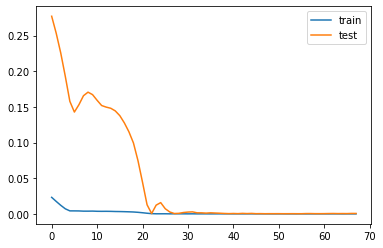

In [25]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

In [26]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [27]:
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

In [28]:
trainPredict[:5]

array([[27.882738],
       [27.63721 ],
       [27.66518 ],
       [28.336515],
       [28.31703 ]], dtype=float32)

In [29]:
trainY = scaler.inverse_transform([trainY])
testY = scaler.inverse_transform([testY])

In [30]:
trainY[0][:5]

array([26.64249951, 26.67499903, 27.45249934, 27.43000031, 27.53000022])

In [31]:
train_rmse = math.sqrt(mean_squared_error(trainY[0],trainPredict[:,0]))
print('Train RMSE: %.2f RMSE'%(train_rmse))

Train RMSE: 0.80 RMSE


In [32]:
test_rmse = math.sqrt(mean_squared_error(testY[0],testPredict[:,0]))
print('Test RMSE: %.2f RMSE'%(test_rmse))

Test RMSE: 2.40 RMSE


In [33]:
train_mae = mean_absolute_error(trainY[0],trainPredict[:,0])
print('Train MAE: %.2f RMSE'%(train_mae))

Train MAE: 0.61 RMSE


In [34]:
test_mae = mean_absolute_error(testY[0],testPredict[:,0])
print('Test MAE: %.2f RMSE'%(test_mae))

Test MAE: 1.66 RMSE


In [35]:
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:,:] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back,:] = trainPredict

In [36]:
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:,:] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1,:] = testPredict

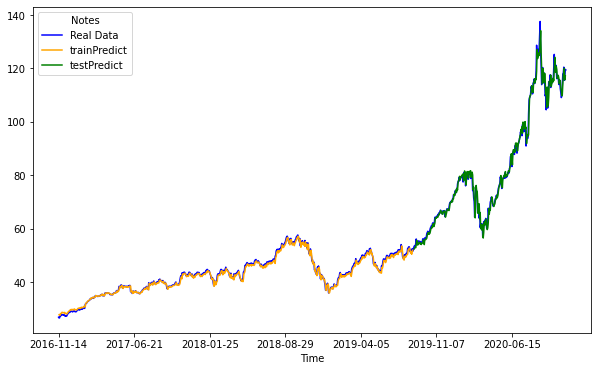

In [40]:
plt.figure(figsize=(10,6))
plt.plot(dataframe.iloc[:].index,scaler.inverse_transform(dataset),label = 'Real Data',color='blue')
plt.plot(trainPredictPlot,label='trainPredict',color='orange')
plt.plot(testPredictPlot,label='testPredict',color='green')
plt.xticks(np.arange(0,len(dataframe),150))
plt.xlabel('Time')
plt.legend(title='Notes')
plt.show()

In [38]:
model.save('Ex5Model.h5')

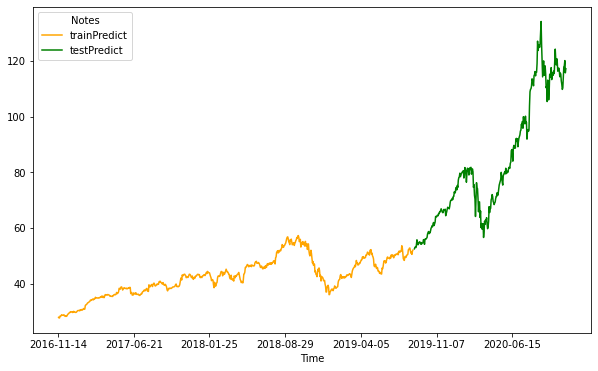

In [42]:
plt.figure(figsize=(10,6))
plt.plot(dataframe.iloc[:].index,trainPredictPlot,label='trainPredict',color='orange')
plt.plot(testPredictPlot,label='testPredict',color='green')
plt.xticks(np.arange(0,len(dataframe),150))
plt.xlabel('Time')
plt.legend(title='Notes')
plt.show()

In [47]:
x_new = scaler.transform([[119.44]])
x_new = numpy.reshape(x_new,(1,1,1))

y_new = model.predict(x_new)
y_new = scaler.inverse_transform(y_new)
y_new

array([[119.16985]], dtype=float32)